# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import problem_unittests as tests
import random
import torchvision
import torch
from torch import optim
import copy, time
from torchvision import datasets
from torchvision import transforms


# manualSeed = 999
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

#import helper

%matplotlib inline
scale_values = (-1, 1)

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transforms_ = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder(data_dir, transform=transforms_)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    
    # TODO: Implement function and return a dataloader
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [3]:
# Define function hyperparameters
batch_size = 128
img_size = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

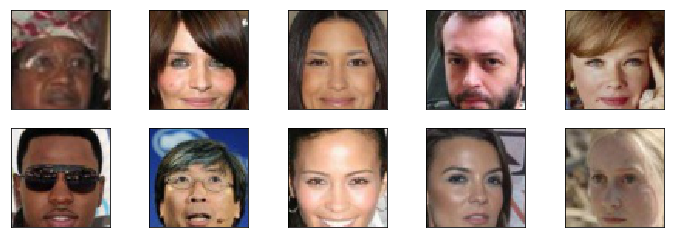

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 4))
plot_size=10
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [5]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    return x * (max - min) + min


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]

print(img.min())
print(img.max())
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

tensor(0.0039)
tensor(0.9961)
Min:  tensor(-0.9922)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Tanh_(nn.Module):
    def __init__(self, in_x, multiplier):
        super().__init__()
        self.in_x = in_x
        self.multiplier = multiplier
    def forward(self, x):
        x = torch.tanh(x * self.in_x) * self.multiplier
        return x

In [8]:
class Swish_(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        x = x * torch.sigmoid(x)
        return x

In [9]:
def conv_block(in_channels, out_channels, 
               kernel_size=4, stride=2, padding=1, 
               batch_norm=True, relu_type='relu', 
               bn_after=True, transposed=False, 
               dropout_prob=0.5, in_x=1.0, multiplier=1.0):
    """
    Creates a convolutional or deconvolutional layer, with optional batch normalization.
    Type of ReLU activation can take the values of selu, leaky_relu or relu
    bn_after sets batchnorm after activation function for experimental purposes
    transposed creates transposed convolutional layers"""
    layers = []

    if transposed:
        layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    else:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        
    if (batch_norm) and (bn_after == False):
        layers.append(nn.BatchNorm2d(out_channels))
        
    relu_types = {
        'selu': nn.SELU(inplace=True),
        'relu': nn.ReLU(inplace=True),
        'leaky_relu': nn.LeakyReLU(0.2, inplace=True),
        'swish': Swish_(),
        'tanh': Tanh_(in_x, multiplier),
        'None': ''
    }
    if relu_type != 'None':
        layers.append(relu_types[relu_type])
    if (batch_norm) and (bn_after):
        layers.append(nn.BatchNorm2d(out_channels))
    if dropout_prob != 0.0:
        layers.append(nn.Dropout2d(p=dropout_prob))
        
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, n_conv_layers=5, batch_norm=True, bn_after=False, relu_type='leaky_relu', img_size=32, dropout_prob=0.0, in_x=1.0, multiplier=1.0):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        :param n_conv_layers: The number of hidden convolutional layers (will always have one)
        :param bn_after: Define whether batchnorm is applied before or after activation function (experimental)
        :param relu_tye: Choose between 'selu', 'relu' or 'leaky_relu' activation functions
        :param img_size: Image size of input (default 32x32)
        """
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.n_conv_layers = n_conv_layers
        self.conv_dim = conv_dim
        
        
        # convolutional layers
        if n_conv_layers > 0:
            conv_dims = [conv_dim * 2 ** layer for layer in range(n_conv_layers)]
        else:
            conv_dims = [conv_dim]
        # 3 dimensional image to conv_dim layer
        self.conv0 = conv_block(3, conv_dims[0], batch_norm=False, relu_type=relu_type, dropout_prob=0.0, in_x=in_x, multiplier=multiplier)
        
        # Multiple layer creation
        if n_conv_layers > 1: 
            conv_layers = [conv_block(conv_dims[n], conv_dims[n+1], batch_norm=batch_norm, bn_after=bn_after, relu_type=relu_type, dropout_prob=dropout_prob, in_x=in_x, multiplier=multiplier) for n in range(n_conv_layers-1)]
            self.hidden_conv = nn.Sequential(*conv_layers)
        self.conv_classifier = conv_block(conv_dims[-1], 1, kernel_size=img_size // 2 ** n_conv_layers, 
                                          stride=1, padding=0, batch_norm=False, relu_type='None', dropout_prob=0.0)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv0(x)
        if self.n_conv_layers > 1:
            x = self.hidden_conv(x)
        x = self.conv_classifier(x)
        x = x.flatten(1)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)


Tests Passed


##### Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self,z_size, conv_dim, 
                 n_conv_layers=4, n_fc_layers=0, 
                 bn_after=False, batch_norm=True, relu_type='relu', 
                 img_size=32, fc_bias=False, 
                 dropout_prob=0.0, multiplier=1.0, in_x=1.0):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        :param n_conv_layers: The number of hidden convolutional layers (will always have one)
        :param n_fc_layers: The number of hidden fully connected layers (will always have one)
        :param bn_after: Define whether batchnorm is applied before or after activation function (experimental)
        :param relu_tye: Choose between 'selu', 'relu' or 'leaky_relu' activation functions
        :param img_size: Image size of input (default 32x32)
        :param fc_bias: Define whether hidden fc layers have biases
        :param conv_tube: Define if tranposed convolutional layers start with img_size size.
        :param sigmoid: define Sigmoid for last activation
        """
        super(Generator, self).__init__()
        self.img_size = img_size
        self.conv_dim = conv_dim
        self.n_conv_layers = n_conv_layers
        self.n_fc_layers = n_fc_layers
        self.img_size_fc_to_conv = self.img_size // 2 ** n_conv_layers
        self.multiplier = multiplier
        self.in_x = in_x
        
        if n_conv_layers > 0:
            conv_dims = [conv_dim * 2 ** layer for layer in reversed(range(n_conv_layers))]
        else:
            conv_dims = [conv_dim]
        
        fc_dims = [conv_dim * (self.img_size_fc_to_conv **2) * 2 ** layer for layer in range(n_fc_layers)] if n_fc_layers > 0 else [z_size]
        
        
        if n_fc_layers > 1:
            self.fc0 = nn.Linear(z_size, fc_dims[0], bias=False)
            fc_layers = [nn.Linear(fc_dims[n], fc_dims[n+1], bias=fc_bias) for n in range(n_fc_layers-1)]
            self.hidden_fc = nn.Sequential(*fc_layers)
        
        self.fc_to_conv = nn.Linear(fc_dims[-1], conv_dims[0]*((self.img_size_fc_to_conv)**2), bias=False)
                
        if n_conv_layers > 1:
            conv_layers = [conv_block(conv_dims[n], conv_dims[n+1], batch_norm=batch_norm, bn_after=bn_after, transposed=True, relu_type=relu_type, dropout_prob=dropout_prob, in_x=in_x, multiplier=multiplier) for n in range(n_conv_layers-1)]
            self.hidden_conv = nn.Sequential(*conv_layers)
        self.conv_to_img = conv_block(conv_dims[-1], 3, batch_norm=False, transposed=True, relu_type='tanh', dropout_prob=0.0, in_x=in_x, multiplier=multiplier)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A Tensor image as output
        """
        # define feedforward behavior

        if self.n_fc_layers > 1:
            x = self.fc0(x)
            x = self.hidden_fc(x)
        x = self.fc_to_conv(x)
        x = x.view(x.size(0), -1, self.img_size_fc_to_conv, self.img_size_fc_to_conv)
        if self.n_conv_layers > 1:
            x = self.hidden_conv(x)
        x = self.conv_to_img(x)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
#     classname = m.__class__.__name__
    
    if (type(m) == nn.Linear) or (type(m) == nn.Conv2d) or (type(m) == nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight.data, 0, 0.02)
    if type(m) == nn.BatchNorm2d:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size, 
                  d_n_conv_layers=4, d_activation='swish', d_dropout_prob=0.0, d_batch_norm=True,
                  g_dropout_prob=0.2, g_n_conv_layers=4, g_n_fc_layers=3, g_fc_bias=False, g_activation='relu', g_batch_norm=True,
                  bn_after=True, img_size=32, multiplier=1.0, in_x=1.0):
    # define discriminator and generator
    D = Discriminator(d_conv_dim, n_conv_layers=d_n_conv_layers, bn_after=bn_after, batch_norm=d_batch_norm,
                      relu_type=d_activation, img_size=img_size, dropout_prob=d_dropout_prob, in_x=in_x, multiplier=multiplier)
    
    G = Generator(z_size=z_size, conv_dim=g_conv_dim, 
                  n_conv_layers=g_n_conv_layers, n_fc_layers=g_n_fc_layers, 
                  bn_after=bn_after, relu_type=g_activation, img_size=img_size, 
                  fc_bias=g_fc_bias, batch_norm=g_batch_norm,
                  dropout_prob=g_dropout_prob, multiplier=multiplier, in_x=in_x)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [59]:
# Model hyperparameters
# Changes tanh activation function to: f(x) = tanh(x * in_x) * multiplier
multiplier = 1.0
in_x = 1.0
bn_after = False

# Input parameters
z_size = 2048
sample_size = 16
fixed_z = torch.FloatTensor(sample_size, z_size).uniform_(-multiplier, multiplier)

# Generator hyperparameters
g_conv_dim = 128
g_fc_bias = False # Bias on the fc layers
g_n_conv_layers = 5 # Number of TConv Layers
g_activation = 'relu' # Type of activation function on the Tranposed Convolutional layers block
g_n_fc_layers=0 # Number of Fully Connected layers for the Generator at the start
g_dropout_prob=0.5
g_batch_norm=True

# Discriminator hyperparameters
d_conv_dim = g_conv_dim
d_n_conv_layers = g_n_conv_layers
d_activation = 'leaky_relu'
d_dropout_prob=0.5
d_batch_norm=True

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size, 
                     d_n_conv_layers=d_n_conv_layers, d_activation=d_activation, d_dropout_prob=d_dropout_prob, d_batch_norm=d_batch_norm,
                     g_n_conv_layers=g_n_conv_layers, g_n_fc_layers=g_n_fc_layers, g_fc_bias=g_fc_bias, g_batch_norm=g_batch_norm,
                     g_dropout_prob=g_dropout_prob, g_activation=g_activation,
                     bn_after=bn_after, img_size=img_size, multiplier=multiplier, in_x=in_x)

Discriminator(
  (conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (hidden_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
      (3): Dropout2d(p=0.5)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
      (3): Dropout2d(p=0.5)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Leaky

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [51]:
def loss_types(D_out, real_loss=True, lambda_value=1.0, delta_value=0.0):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if real_loss:
        labels = torch.FloatTensor(batch_size).uniform_(lambda_value-delta_value, lambda_value+delta_value)
    else:
        labels = torch.FloatTensor(batch_size).uniform_(0.0,0.0+delta_value*1.5)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(D_out.squeeze(), labels)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

In [18]:
def train(D, G, d_optimizer, g_optimizer, n_epochs, fixed_z, print_every=50,
          lambda_value=1.0, delta_value=0.0, 
          img_list=[], scale_values=(-1, 1), train_type='full'):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       param, loss_metric: choose between MSE or BCEWithLogitsLoss loss function
       param, lambda_value: choose label smoothing value in MSE and BCEWithLogitsLoss
       param, delta_value: label smoothing to random value between lambda_value - delta_value and lambda_value + delta_value
       param, beta1: define beta1
       param, beta1_delta: define random variation interval of beta1
       param, beta2: define beta2
       param, beta2_delta: define random variation interval of beta2
       param, img_list: saves fixed samples on each print_every to a list
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    accuracy = []
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    if (train_type == 'D') or (train_type == 'split'):
        train_D, train_G = True, False
    elif train_type == 'G':
        train_D, train_G = False, True
    else:
        train_D, train_G = True, True    
    # epoch training loop
    for epoch in range(n_epochs):
        if train_type == 'split':
            if epoch == n_epochs//3:
                train_D, train_G = False, True
            if epoch == 2*n_epochs//3:
                train_D, train_G = True, True

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            
            batch_size = real_images.size(0)
            real_images = scale(real_images, (scale_values[0], scale_values[1]))

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            D.zero_grad()
            z = torch.FloatTensor(batch_size, z_size).uniform_(scale_values[0], scale_values[1])
            
            if train_on_gpu: 
                z = z.cuda()
                real_images = real_images.cuda()
            D_real = D(real_images)
            D_real_loss = loss_types(D_real, real_loss=True, lambda_value=lambda_value, delta_value=delta_value)
            # From DCGAN Pytorch Tutorial
            if train_D:
                D_real_loss.backward()
            
            fake = G(z)
            D_fake = D(fake.detach())
            D_fake_loss = loss_types(D_fake, real_loss=False, lambda_value=lambda_value, delta_value=delta_value)
            # From DCGAN Pytorch tutorial
            if train_D:    
                D_fake_loss.backward()
                d_optimizer.step()
            d_loss = D_real_loss + D_fake_loss            

            # 2. Train the generator with an adversarial loss
            G.zero_grad()

            D_G_fake = D(fake)
            g_loss = loss_types(D_G_fake, real_loss=True, lambda_value=lambda_value, delta_value=delta_value)
            if train_G:
                g_loss.backward()
                g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                D_x = torch.sigmoid_(D_real.detach()).mean()
                D_G_z = torch.sigmoid_(D_fake.detach()).mean()
                D_G_z_g = torch.sigmoid_(D_G_fake.detach()).mean()
                
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                accuracy.append((D_x.item(), D_G_z.item(), D_G_z_g.item()))
                
                # print discriminator and generator loss
                print(f'[{epoch+1:3}/{n_epochs:3}][{batch_i:3}/{len(celeba_train_loader):3}]\t',
#                 f'Loss_D: {d_loss.item():.2f}\t',
                f'[Losses D: {d_loss.item():.2f} (R {D_real_loss:.2f} + F {D_fake_loss:.2f}) | G: {g_loss.item():.2f}]\t',
#                 f'Losses_D: {d_loss.item():.2f} [{D_real_loss:.2f} | {D_fake_loss:.2f}]\t',
#                 f'Loss_G: {g_loss.item():.2f}\t',
                f'[D(x): {D_x:.2f}]\t',
                f'[D(G(z)): {D_G_z:.2f} | {D_G_z_g:.2f}]\t',
                f'[Train D: {train_D} | G: {train_G}]')
    
#                 fake = G(fixed_z).detach().cpu()
#                 img_list.append(torchvision.utils.make_grid(fake, padding=0, range=(scale_values[0], scale_values[1])))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
                G.eval() # for generating samples
                samples_z = G(fixed_z)
        #         samples.append(samples_z)
                img_list.append(torchvision.utils.make_grid(samples_z.detach().cpu(), padding=2, normalize=True, range=(scale_values[0], scale_values[1])))
                G.train() # back to training mode

        # Save training generator samples
#         with open('train_samples.pkl', 'wb') as f:
#             pkl.dump(samples, f)
        # Save training generator images
        with open('train_images.pkl', 'wb') as f:
            pkl.dump(img_list, f)
    
    # finally return losses and models' accuracy
    return losses, accuracy

Set your number of training epochs and train your GAN!

In [19]:
def view_samples(epoch, samples, img_size=32, multiplier=1.0):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=False, sharex=False)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + multiplier)*255 / (multiplier * 2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_size,img_size,3)))

def plot_model(losses, accuracy, show_epoch_0=True, show_accuracy=True):
    print('-' * 80)
    print(f'Model trained for {n_epochs} epochs on {time.asctime()}')
    print(f'Image Size: {img_size}x{img_size}\tbatch size: {batch_size}\tmultiplier: {multiplier} - in_x: {in_x}')
    print(f'Discriminator final layer depth: {d_conv_dim}\tGenerator initial layer depth: {g_conv_dim}')
    print(f'Discriminator Dropout: {d_dropout_prob}\t Generator Dropout: {g_dropout_prob}')
    print(f'Optimizer:\t[G_LR: {g_lr} | D_LR: {d_lr}]\tbeta1: {beta1}\tbeta2: {beta2}')
    print(f'Loss: Lambda: {lambda_value}\tDelta: {delta_value}')
    print(f'Z size: {z_size}\tNumber of Conv/Deconv Layers: {d_n_conv_layers}')
    print(f'Discriminator Activation Function: {d_activation}\t Generator Activation Function: {g_activation}')
    print('-' * 80)
    
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Training Images")
    # plt.imshow(np.transpose(torchvision.utils.make_grid(img_list, padding=2, normalize=True, range=(-multiplier, multiplier)).cpu(),(1,2,0)))
    plt.imshow(np.transpose(torchvision.utils.make_grid(img_list[-1], padding=2).cpu(),(1,2,0)));

    plt.figure(figsize=(20,5));
    plt.subplot(1, 2, 1)
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    if show_accuracy:
        plt.subplot(1, 2, 2)
        accuracy = np.array(accuracy)
        plt.plot(accuracy.T[0], label='D(x)', alpha=0.5)
        plt.plot(accuracy.T[1], label='D(G(z))', alpha=0.5)
        plt.plot(accuracy.T[2], label='D(G(z_g))', alpha=0.5)
        plt.title("Accuracy")
        plt.legend();
        plt.figure(figsize=(20,5));

    plt.tight_layout()
    plt.show();


In [ ]:
# set number of epochs 
n_epochs = 30

beta1= 0.5
beta2= 0.999
lambda_value = 0.9
delta_value = 0.1
img_list = []
train_type = 'full'

g_lr = 0.0002
d_lr = g_lr
d_optimizer = optim.Adam(D.parameters(), d_lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), g_lr, [beta1, beta2])

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

losses, accuracy = train(D, G, d_optimizer, g_optimizer, n_epochs=n_epochs, fixed_z=fixed_z, print_every=len(celeba_train_loader)//10, 
                        lambda_value=lambda_value, delta_value=delta_value,
                         img_list=img_list, scale_values=(-multiplier, multiplier), 
                         train_type=train_type)

plot_model(losses, accuracy)

[  1/ 30][  0/703]	 [Losses D: 0.68 (R 0.38 + F 0.30) | G: 0.56]	 [D(x): 0.77]	 [D(G(z)): 0.04 | 0.61]	 [Train D: True | G: True]


--------------------------------------------------------------------------------
Model trained for 30 epochs on Thu Apr 11 10:27:33 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 64	Generator initial layer depth: 64
Discriminator Dropout: 0.5	 Generator Dropout: 0.5
Optimizer:	[G_LR: 0.0002 | D_LR: 0.0002]	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.9	Delta: 0.1
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: leaky_relu	 Generator Activation Function: relu
--------------------------------------------------------------------------------


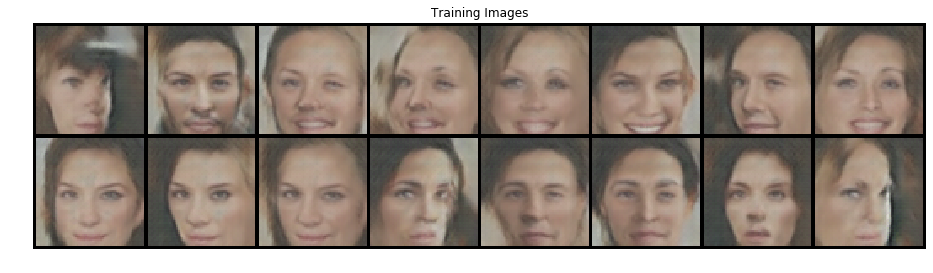

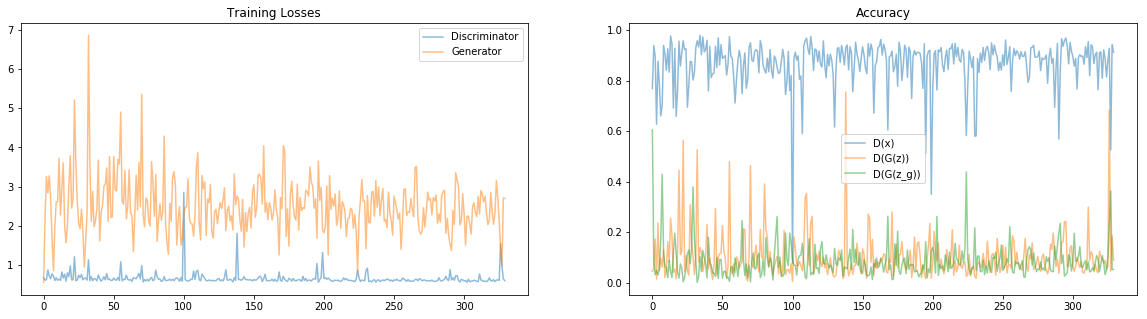

<Figure size 1440x360 with 0 Axes>

In [67]:
plot_model(losses, accuracy)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

My dataset consists mainly of white celebrity faces therefore my GAN produces mostly white faces. This could be improved by having the same number of samples of each ethnicity group. Even more interesting would be to have the percentage of the global population represented in the samples in ethnicity! This would create a GAN that would create the best **average** representation face of the human race!

My model size is rather small (64x64 pixels for input size, 5 layers for both Generator and Discriminator networks). NVIDIA's latest GAN outputs have been 1024x1024! Having a bigger size for my model would mean more feature extraction, deeper network and rather longer training times.

I found out that training for a very very large amount of epochs wasn't improving my network after a few epochs. I decided to set the dimension size to 128 since I wanted to get as many features as I could from the rather small image size input. My optimizers were based on the research and I set beta1 to 0.5 and beta2 to 0.999 as recommended by the linked research paper. As you can see after this answer, I've left multiple experiments I did on this project.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

# Studying Activation function Tanh(x) and Sigmoid(x)
I noticed Sigmoid and Tanh are very similar in function, that sigmoid(2x) * 2 - 1 = tanh(x) so I decided to make a few tests on whether expanding or contracting the curve of tanh would have any effects on the model training. It appeared that with every other variable equal, tan(x * 3) was having better results than the standard tanh(x). I also suspect the learning rate is correlated with **y** with tanh(x * y)! I'll continue further studying after this project.

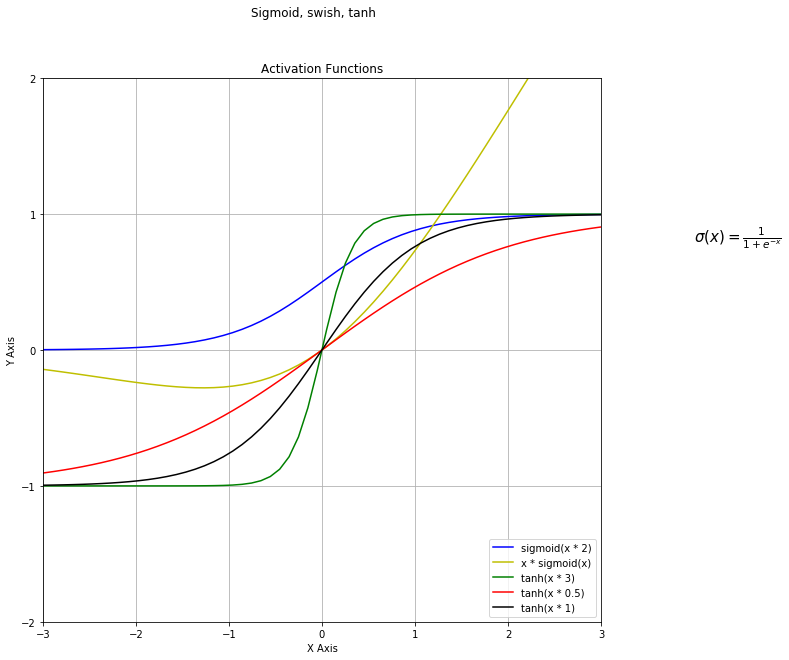

In [12]:
import pylab as plt

#sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return (1 / (1 + np.exp(-x)) - 0)

# generate an Array with value ???
# linespace generate an array from start and stop value
# with requested number of elements. Example 10 elements or 100 elements.
# 
plt.figure(figsize=(10,10))
x = plt.linspace(-5,5,100)
# y = plt.linspace(-5,5,100)
x_mult0 = 2
x_mult1 = 3
x_mult2 = 0.5
x_mult3 = 1
# prepare the plot, associate the color r(ed) or b(lue) and the label 
# plt.plot(x, sigmoid(x), 'r', label='linspace(-10,10,10)')
plt.plot(x, sigmoid(x*x_mult0), 'b', label=f'sigmoid(x * {x_mult0})')
plt.plot(x, x * sigmoid(x), 'y', label=f'x * sigmoid(x)')
# plt.plot(y, sigmoid(y), 'r')
plt.plot(x, np.tanh(x*x_mult1), 'g', label=f'tanh(x * {x_mult1})')
plt.plot(x, np.tanh(x*x_mult2), 'r', label=f'tanh(x * {x_mult2})')
plt.plot(x, np.tanh(x*x_mult3), 'k', label=f'tanh(x * {x_mult3})')

# Draw the grid line in background.
plt.grid()

# Title & Subtitle
plt.title('Activation Functions')
plt.suptitle('Sigmoid, swish, tanh')

# place the legen boc in bottom right of the graph
plt.legend(loc='lower right')

# write the Sigmoid formula
plt.text(4, 0.8, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=15)

#resize the X and Y axes
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))
 

# plt.plot(x)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.axis([-3, 3, -2, 2])



# create the graph
plt.show()

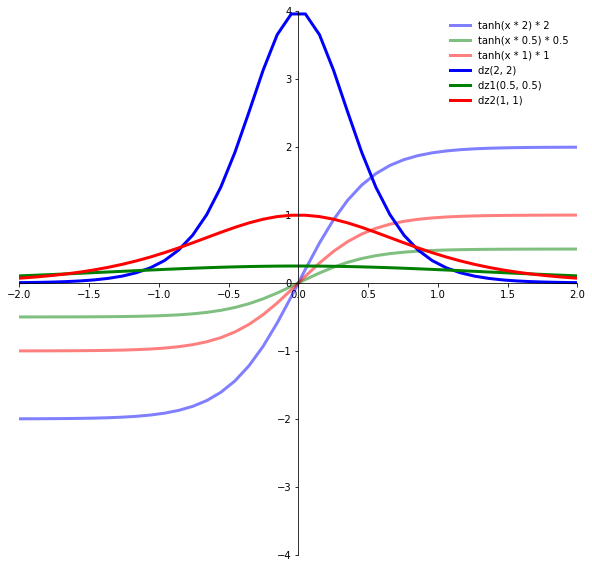

In [17]:
# Calculate plot points
z = np.arange(-10., 10., 0.01)

k = 2
m0 = 2
a = np.tanh(x * k) * m0
dz = -k * m0 * np.tanh(k * x)**2 + k * m0

k1 = 0.5
m1 = 0.5
b = np.tanh(x * k) * m1
dz1 = -k1 * m1 * np.tanh(k1 * x)**2 + k1 * m1

k2 = 1
m2 = 1
c = np.tanh(x * k) * m2
dz2 = -k2 *m2* np.tanh(k2 * x)**2 + k2*m2



# Setup centered axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.axis([-2, 2, -4, 4])


# Create and show plot
ax.plot(x,a, color="b", linewidth=3, label=f"tanh(x * {k}) * {m0}", alpha=0.5)
ax.plot(x,b, color="g", linewidth=3, label=f"tanh(x * {k1}) * {m1}", alpha=0.5)
ax.plot(x,c, color="r", linewidth=3, label=f"tanh(x * {k2}) * {m2}", alpha=0.5)
ax.plot(x,dz, color="b", linewidth=3, label=f"dz({k}, {m0})")
ax.plot(x,dz1, color="g", linewidth=3, label=f"dz1({k1}, {m1})")
ax.plot(x,dz2, color="r", linewidth=3, label=f"dz2({k2}, {m2})")
ax.legend(loc="upper right", frameon=False)
fig.show()

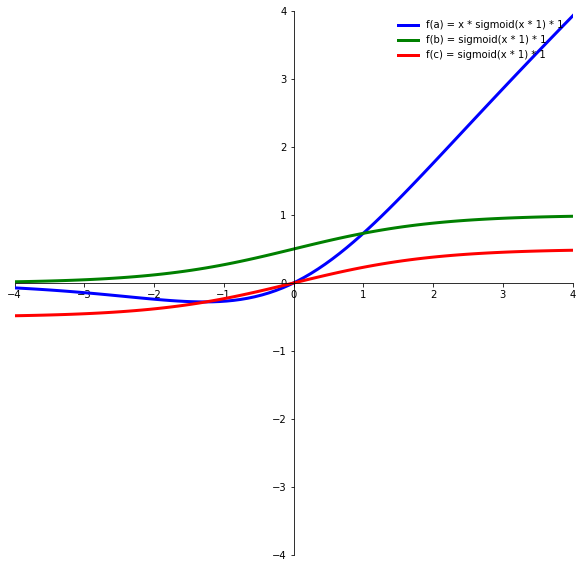

In [24]:
# Calculate plot points
z = np.arange(-10., 10., 0.01)

k = 1
m0 = 1
a = x * sigmoid(x)
b = sigmoid(x)
c = sigmoid(x) - 0.5
dz = -k * m0 * np.tanh(k * x)**2 + k * m0


# Setup centered axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.axis([-4, 4, -4, 4])


# Create and show plot
ax.plot(x,a, color="b", linewidth=3, label=f"f(a) = x * sigmoid(x * {k}) * {m0}")
ax.plot(x,b, color="g", linewidth=3, label=f"f(b) = sigmoid(x * {k}) * {m0}")
ax.plot(x,c, color="r", linewidth=3, label=f"f(c) = sigmoid(x * {k}) * {m0}")

ax.legend(loc="upper right", frameon=False)
fig.show()

In [53]:
from sympy import *
x, y, z = symbols('x y z')
init_printing(use_unicode=True)

In [55]:
diff(tanh(x*3)*2, x)

# Model experiments

----------------------------------------------------------------------------------------------------
Model trained for 3 epochs on Mon Apr  8 17:20:19 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 32	Generator initial layer depth: 32
Discriminator Dropout: 0.1	 Generator Dropout: 0.1
Optimizer:	[G_LR: 0.0002 | D_LR: 5e-05]	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.95	Delta: 0.05
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: leaky_relu	 Generator Activation Function: relu



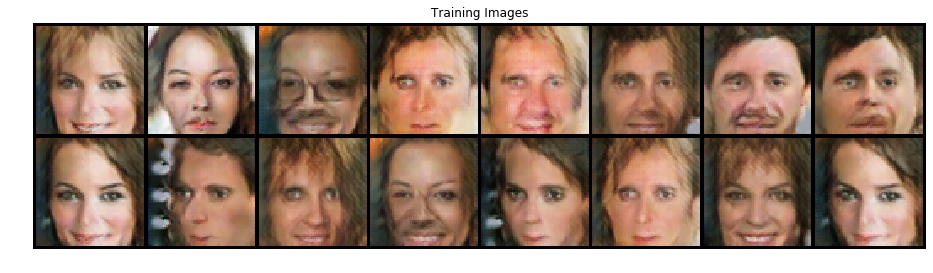

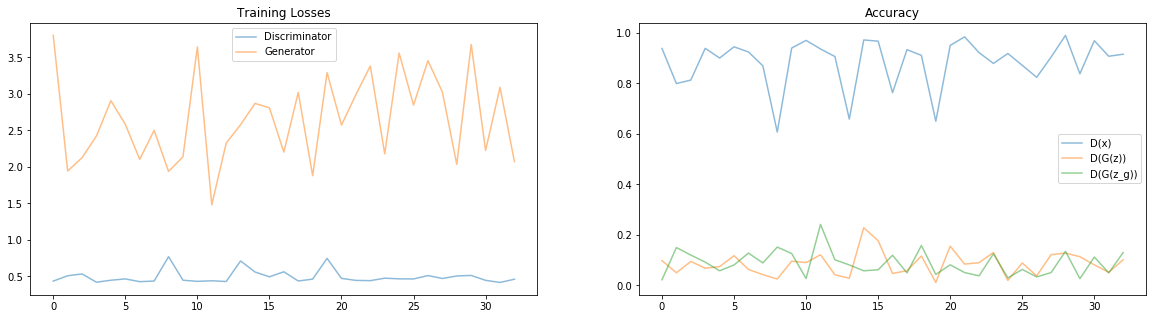

<Figure size 1440x360 with 0 Axes>

In [127]:
plot_model(losses, accuracy)

----------------------------------------------------------------------------------------------------
Model trained for 3 epochs on Mon Apr  8 17:11:19 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 32	Generator initial layer depth: 32
Discriminator Dropout: 0.1	 Generator Dropout: 0.1
Optimizer:	[G_LR: 0.0001 | D_LR: 2.5e-05]	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.95	Delta: 0.12
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: leaky_relu	 Generator Activation Function: relu



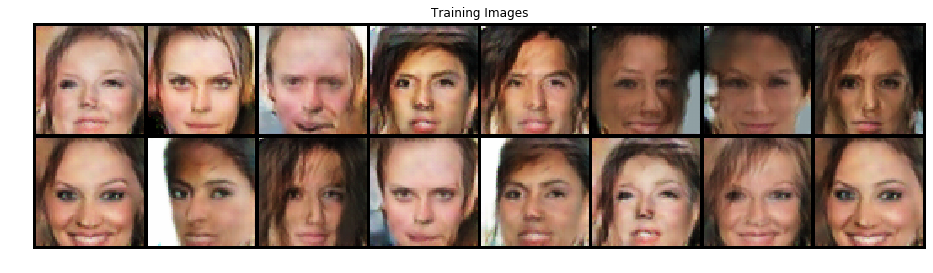

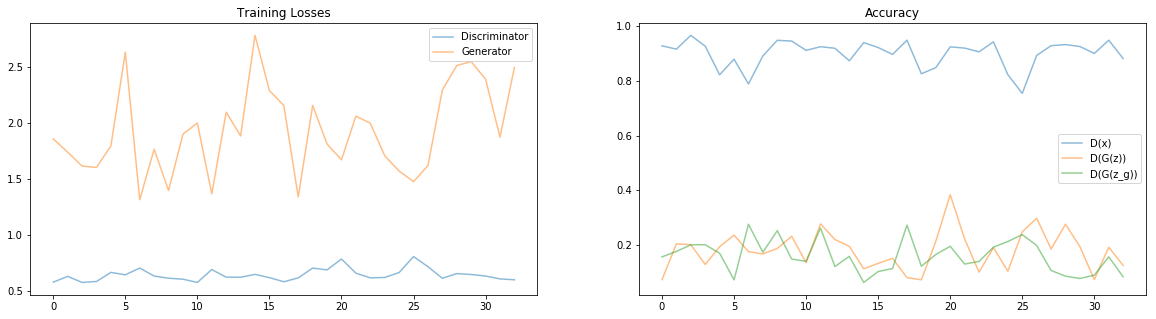

<Figure size 1440x360 with 0 Axes>

In [116]:
plot_model(losses, accuracy)

----------------------------------------------------------------------------------------------------
Model trained for 3 epochs on Mon Apr  8 16:54:09 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 32	Generator initial layer depth: 32
Discriminator Dropout: 0.1	 Generator Dropout: 0.1
Optimizer:	[G_LR: 0.0001 | D_LR: 5e-05]	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.95	Delta: 0.15
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: leaky_relu	 Generator Activation Function: relu



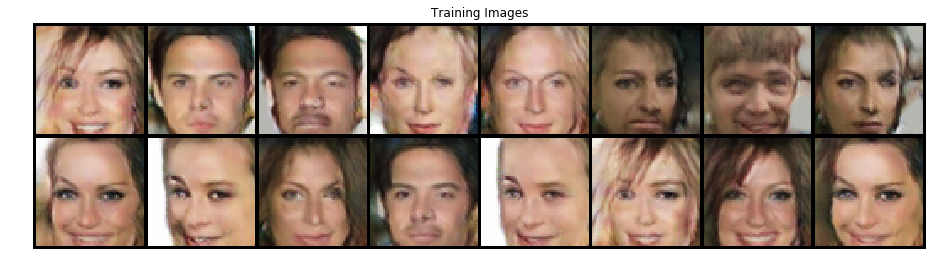

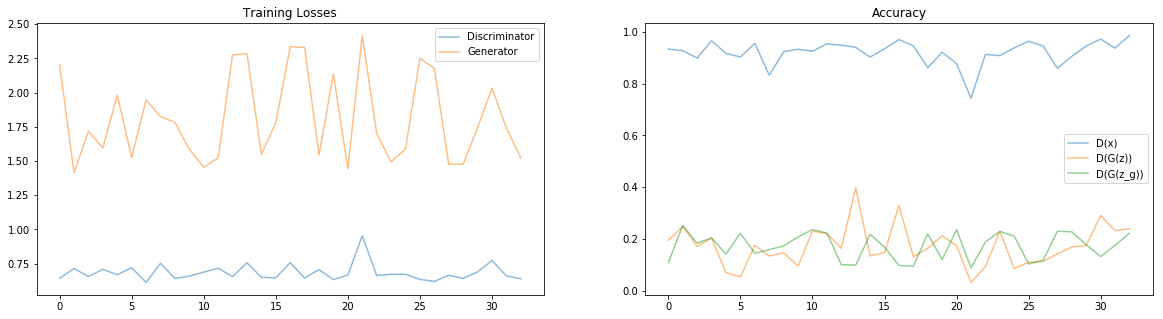

<Figure size 1440x360 with 0 Axes>

In [103]:
plot_model(losses, accuracy)

Model hyperparameters trained for 3 epochs on Mon Apr  8 16:40:28 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 32	Generator initial layer depth: 32
Discriminator Dropout: 0.1	 Generator Dropout: 0.1
Optimizer:	lr: 0.0002	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.95	Delta: 0.15
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: leaky_relu	 Generator Activation Function: relu



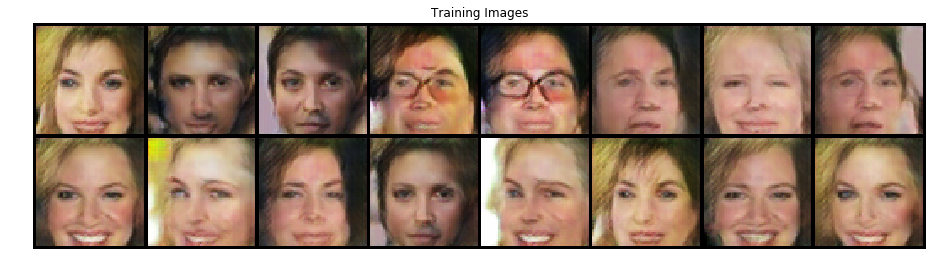

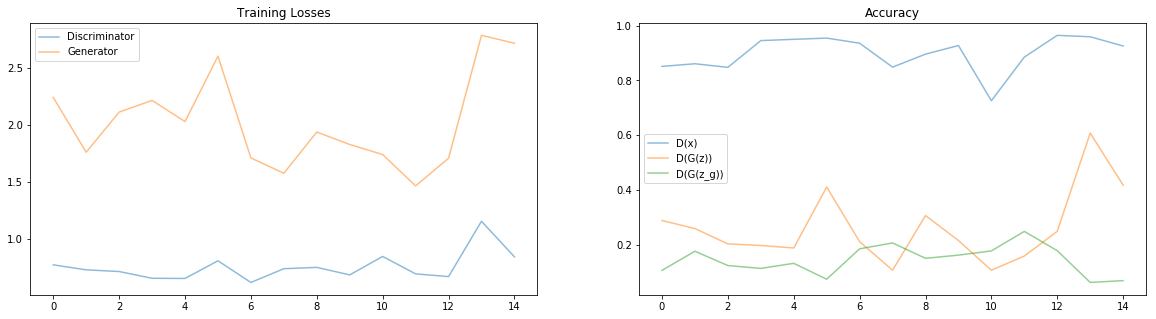

<Figure size 1440x360 with 0 Axes>

In [95]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 3 epochs on Mon Apr  8 16:11:32 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 32	Generator initial layer depth: 32
Discriminator Dropout: 0.1	 Generator Dropout: 0.1
Optimizer:	lr: 0.0002	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.95	Delta: 0.15
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: leaky_relu	 Generator Activation Function: relu



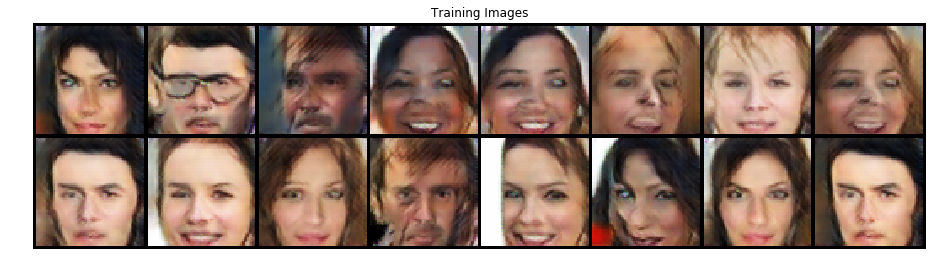

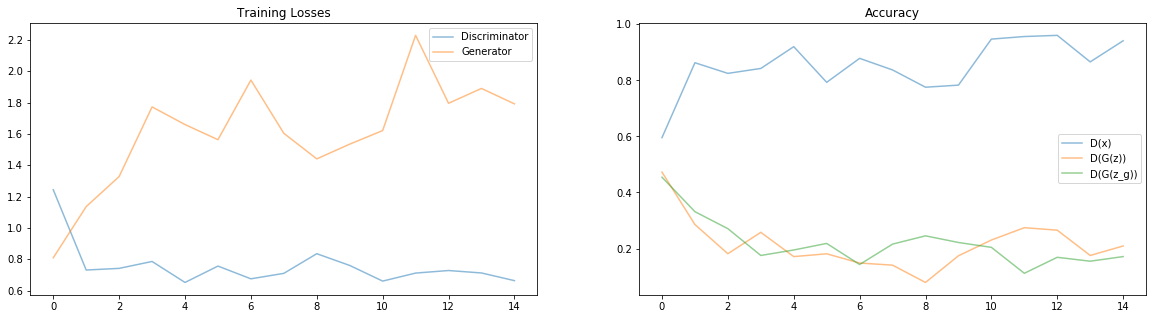

<Figure size 1440x360 with 0 Axes>

In [93]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 20 epochs on Mon Apr  8 13:02:43 2019
Image Size: 64x64	batch size: 128	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 128	Generator initial layer depth: 128
Discriminator Dropout: 0.0	 Generator Dropout: 0.25
Optimizer:	lr: 0.0002	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.85	Delta: 0.15
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: relu



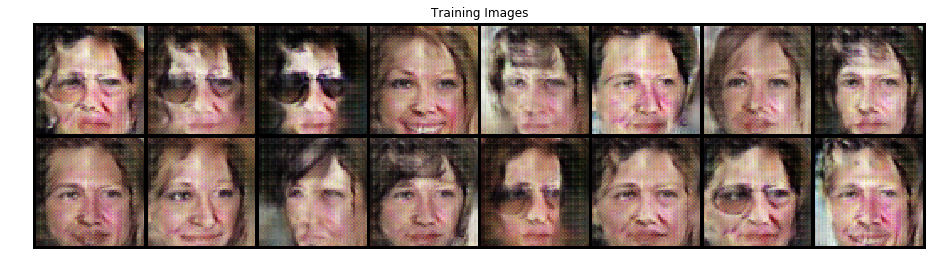

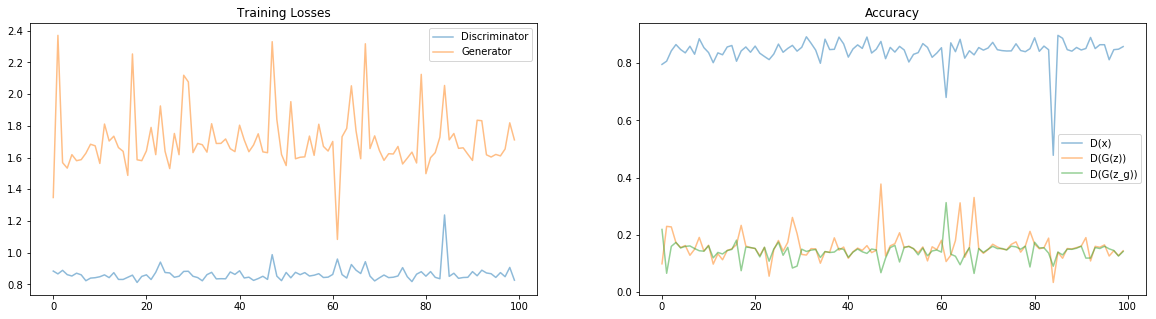

<Figure size 1440x360 with 0 Axes>

In [42]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 5 epochs on Sun Apr  7 17:37:48 2019
Image Size: 64x64	batch size: 64	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 128	Generator initial layer depth: 128
Discriminator Dropout: 0.0	 Generator Dropout: 0.25
Optimizer:	lr: 0.0002	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.85	Delta: 0.25
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: relu



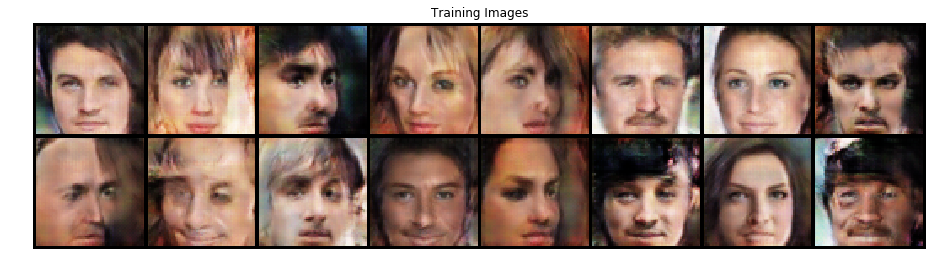

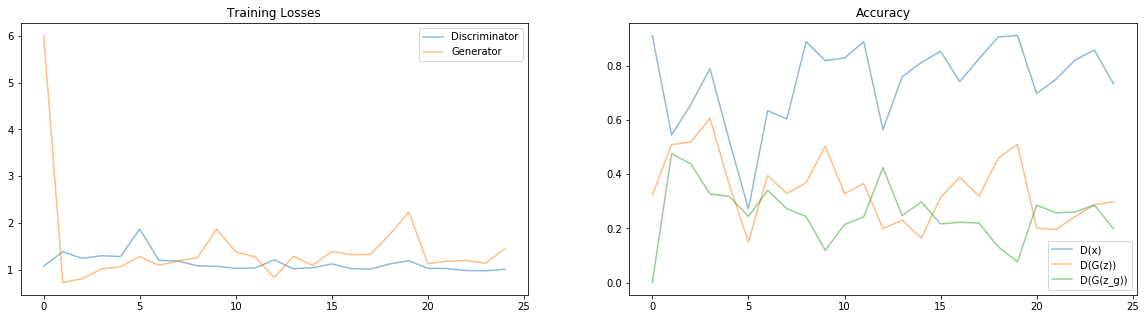

<Figure size 1440x360 with 0 Axes>

In [29]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 5 epochs on Sun Apr  7 16:37:55 2019
Image Size: 64x64	batch size: 64	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 128	Generator initial layer depth: 128
Discriminator Dropout: 0.0	 Generator Dropout: 0.25
Optimizer:	lr: 0.0002	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.85	Delta: 0.25
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: relu



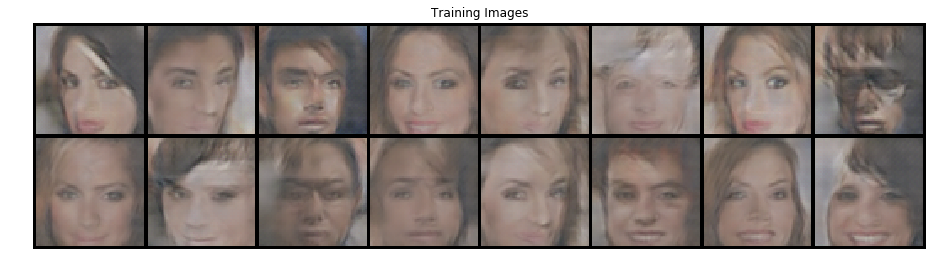

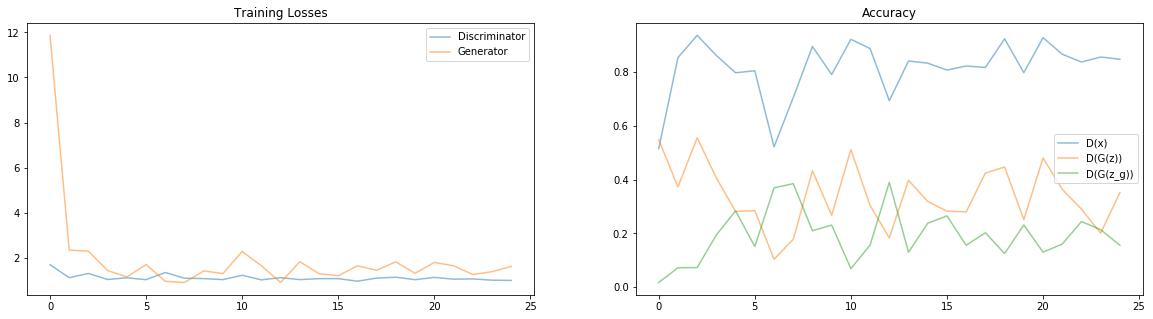

<Figure size 1440x360 with 0 Axes>

In [27]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 5 epochs on Sun Apr  7 13:47:44 2019
Image Size: 64x64	batch size: 64	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 40	Generator initial layer depth: 40
Discriminator Dropout: 0.0	 Generator Dropout: 0.25
Optimizer:	lr: 0.0002	beta1: 0.5	beta2: 0.999
Loss: Lambda: 0.75	Delta: 0.25
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: relu



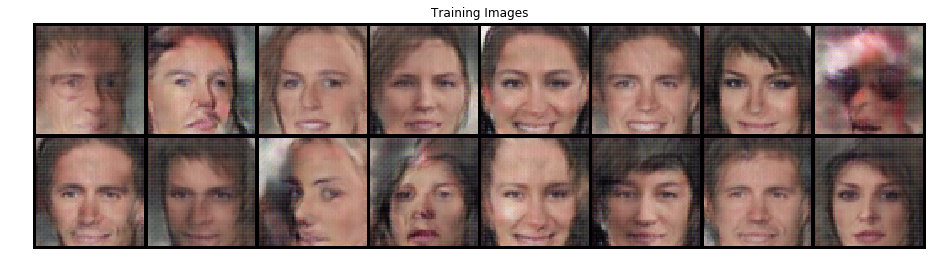

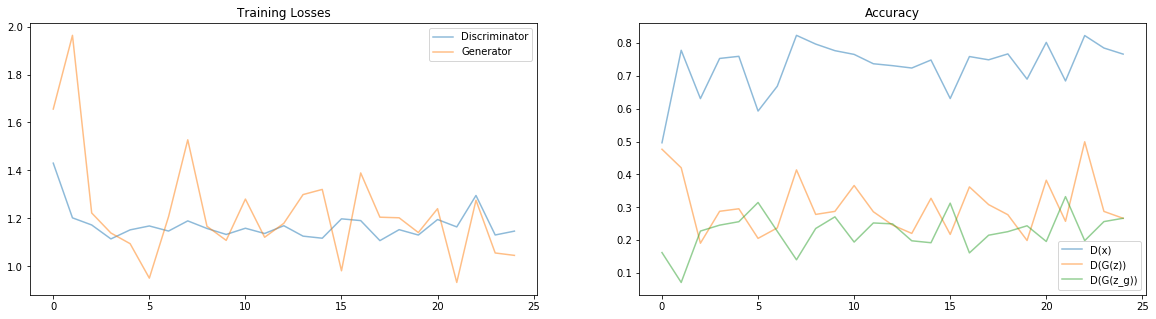

<Figure size 1440x360 with 0 Axes>

In [154]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 5 epochs on Sun Apr  7 13:19:27 2019
Image Size: 64x64	batch size: 64	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 64	Generator initial layer depth: 64
Discriminator Dropout: 0.0	 Generator Dropout: 0.3
Optimizer:	lr: 0.0002	beta1: 0.45	beta2: 0.999
Loss: Lambda: 0.75	Delta: 0.25
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: relu



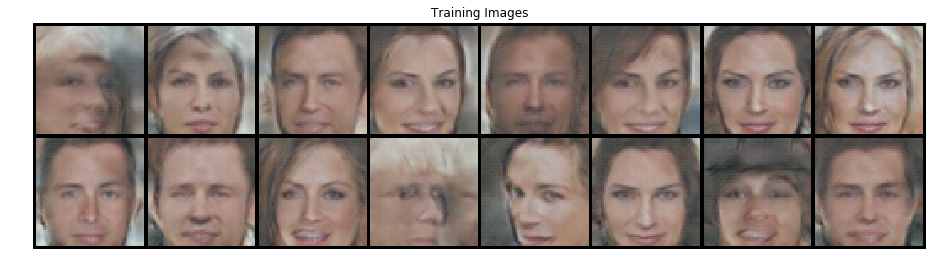

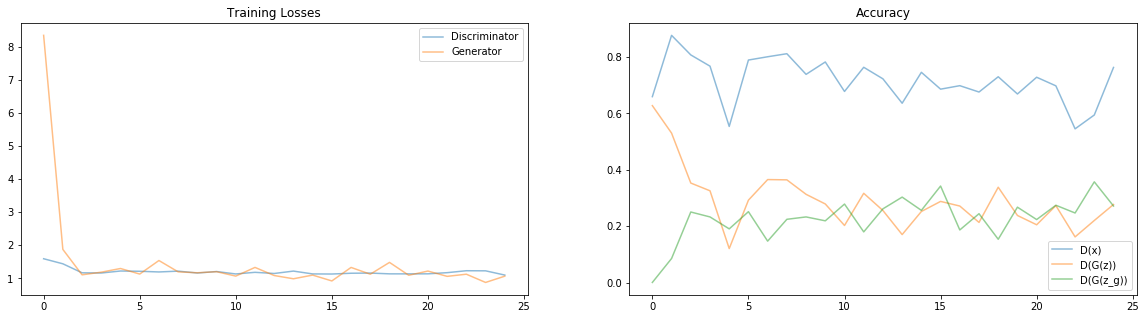

<Figure size 1440x360 with 0 Axes>

In [151]:
plot_model2(losses, accuracy)

Model hyperparameters trained for 3 epochs on Fri Apr  5 18:03:23 2019
Image Size: 64x64	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 64	Generator initial layer depth: 64
Optimizer:	lr: 0.0002	beta1: 0.2 - beta1_delta: 0.0	beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce	Lambda: 0.95	Delta: 0.15
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: swish



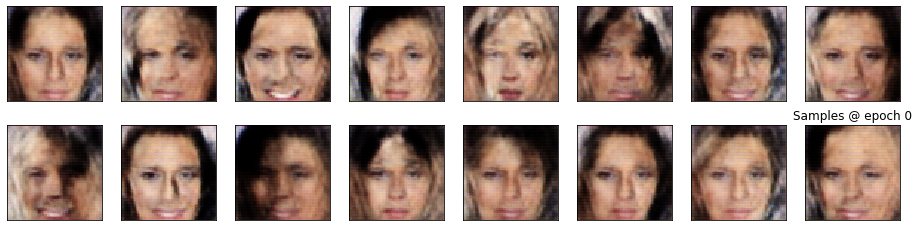

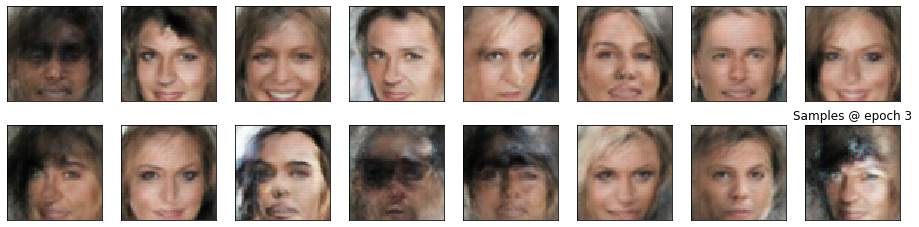

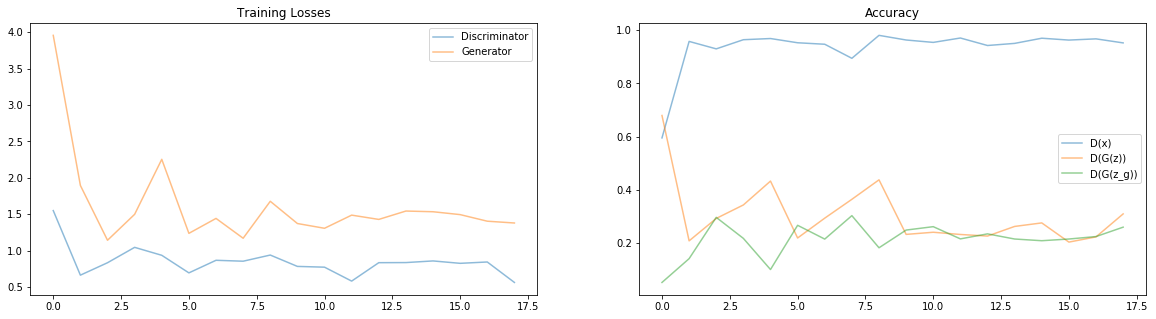

<Figure size 1440x360 with 0 Axes>

In [125]:
plot_model()

Model hyperparameters trained for 3 epochs on Fri Apr  5 16:42:58 2019
Image Size: 64x64	multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 64	Generator initial layer depth: 64
Optimizer:	lr: 0.0002	beta1: 0.3 - beta1_delta: 0.0	beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce	Lambda: 1.0	Delta: 0.15
Z size: 4096	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: swish



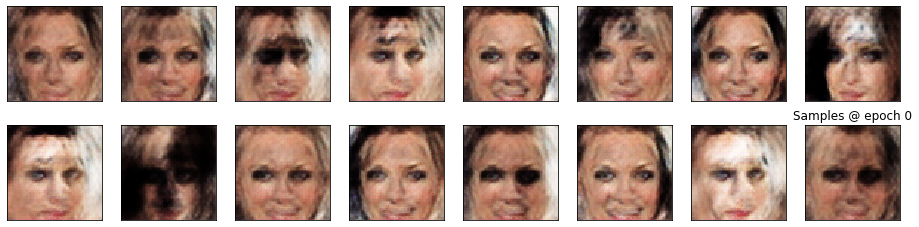

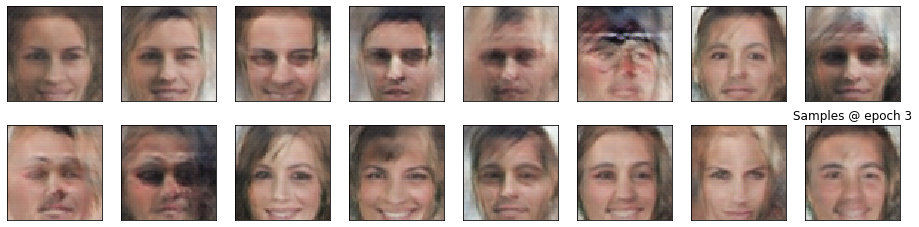

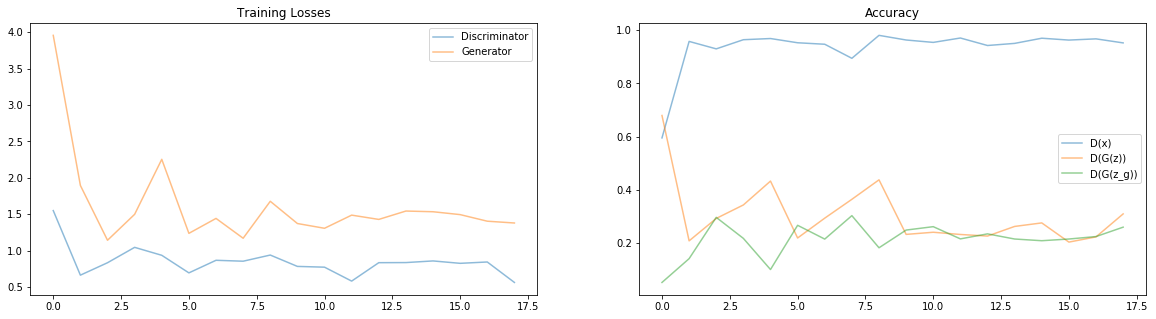

<Figure size 1440x360 with 0 Axes>

In [45]:
plot_model()

Model hyperparameters trained for 3 epochs on Fri Apr  5 16:06:02 2019
Image Size: 64x64	multiplier: 0.9 - in_x: 0.9
Discriminator final layer depth: 64	Generator initial layer depth: 64
Optimizer:	lr: 0.0002	beta1: 0.5 - beta1_delta: 0.0	beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce	Lambda: 0.9	Delta: 0.15
Z size: 2048	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: swish



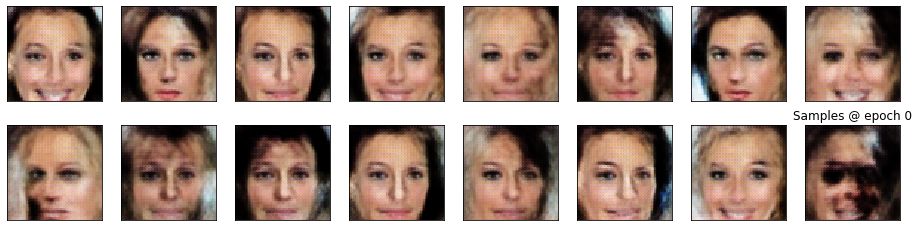

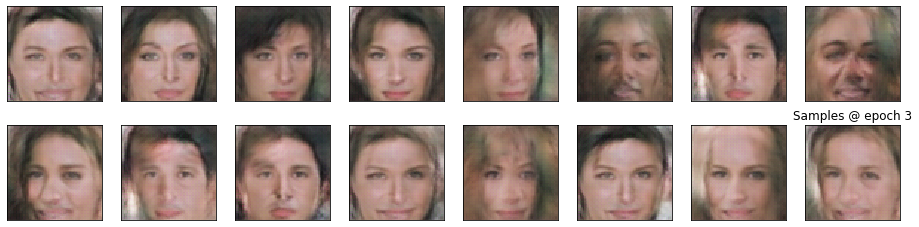

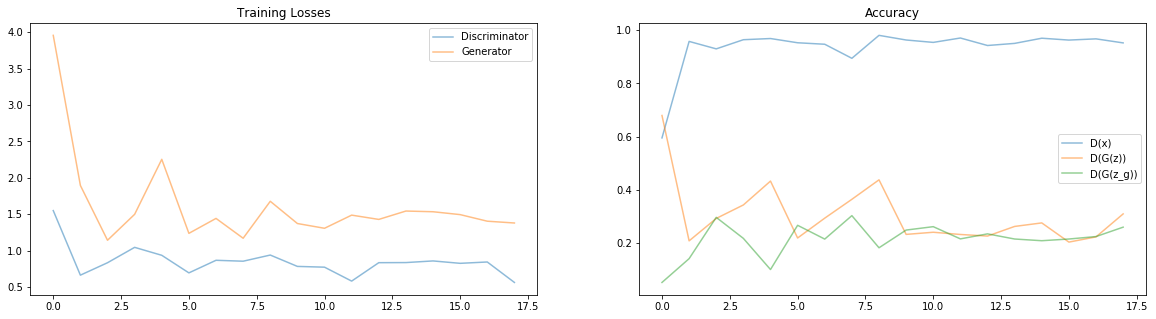

<Figure size 1440x360 with 0 Axes>

In [39]:
plot_model()

Model hyperparameters trained for 6 epochs
Image Size: 64x64	multiplier: 10.0 - in_x: 5.0
Discriminator final layer depth: 64	Generator initial layer depth: 64
Optimizer:	lr: 0.0002	beta1: 0.5 - beta1_delta: 0.0	beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce	Lambda: 0.95	Delta: 0.15
Z size: 4098	Number of Conv/Deconv Layers: 5
Discriminator Activation Function: swish	 Generator Activation Function: swish



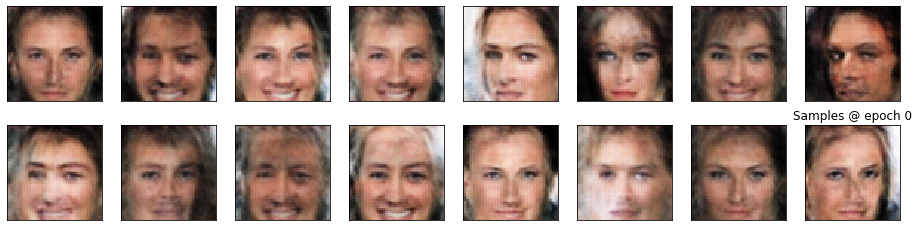

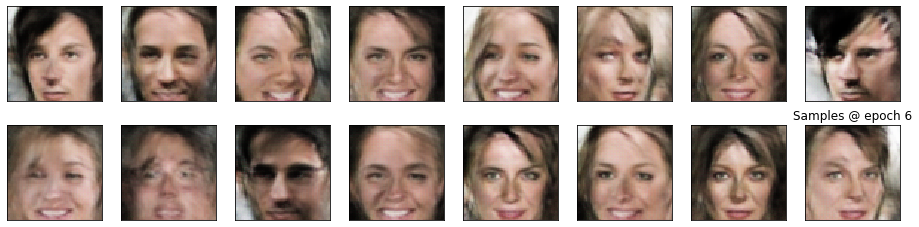

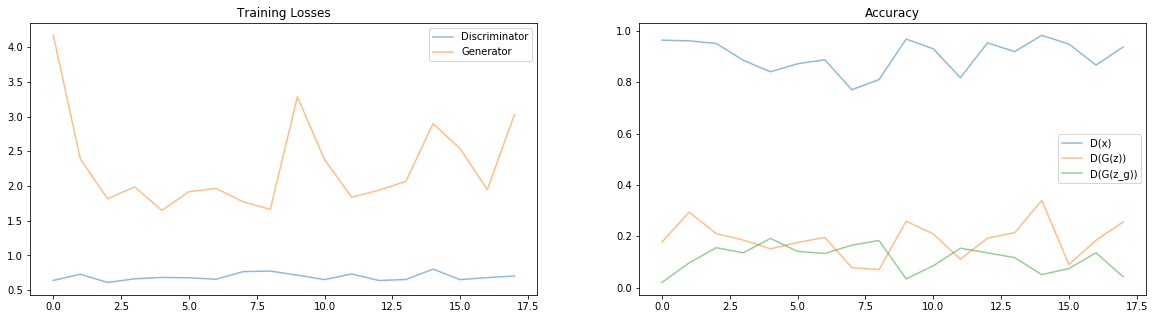

<Figure size 1440x360 with 0 Axes>

In [124]:
plot_model()

Model hyperparameters
Image Size: 64x64 - multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 64	Generator initial layer depth: 64
Optimizer: lr: 0.0002 - beta1: 0.5 - beta1_delta: 0.0 - beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce - Lambda: 0.95 - Delta: 0.15
Z size: 2048 - Number of Conv/Deconv Layers: 5



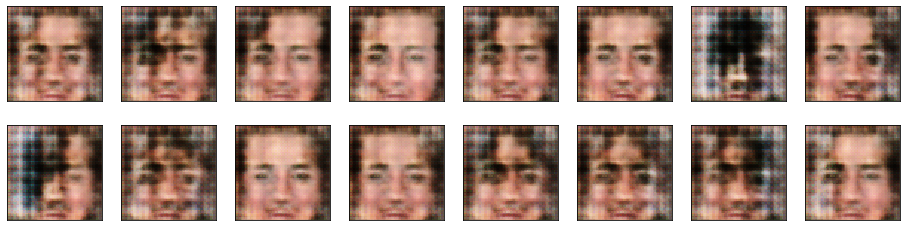

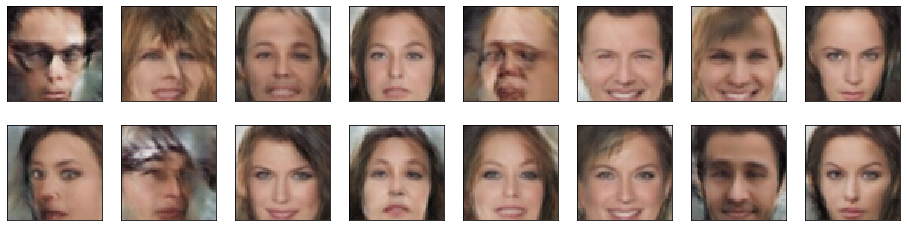

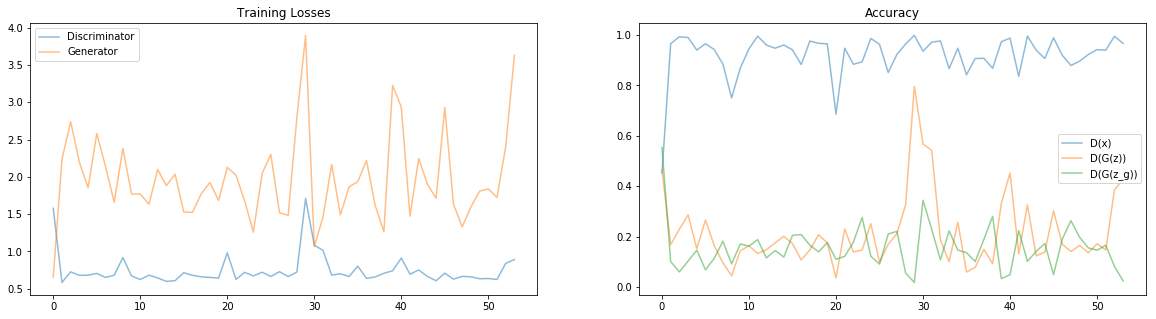

<Figure size 1440x360 with 0 Axes>

In [77]:
plot_model(losses, accuracy)

Model hyperparameters
Image Size: 64x64 - multiplier: 0.8 - in_x: 0.8
Discriminator final layer depth: 32	Generator initial layer depth: 32
Optimizer: lr: 0.0002 - beta1: 0.5 - beta1_delta: 0.0 - beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce - Lambda: 0.95 - Delta: 0.15
Z size: 2048 - Number of Conv/Deconv Layers: 5



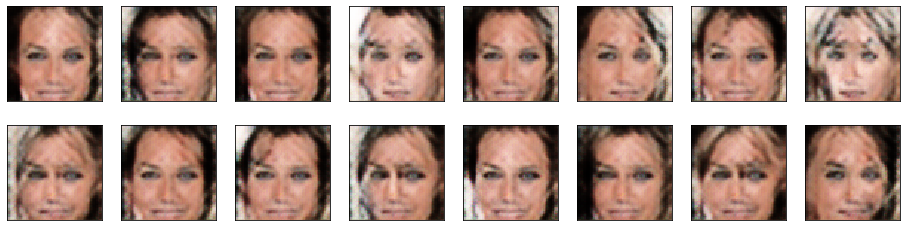

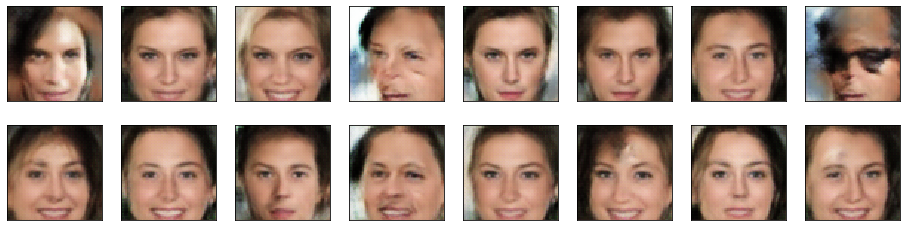

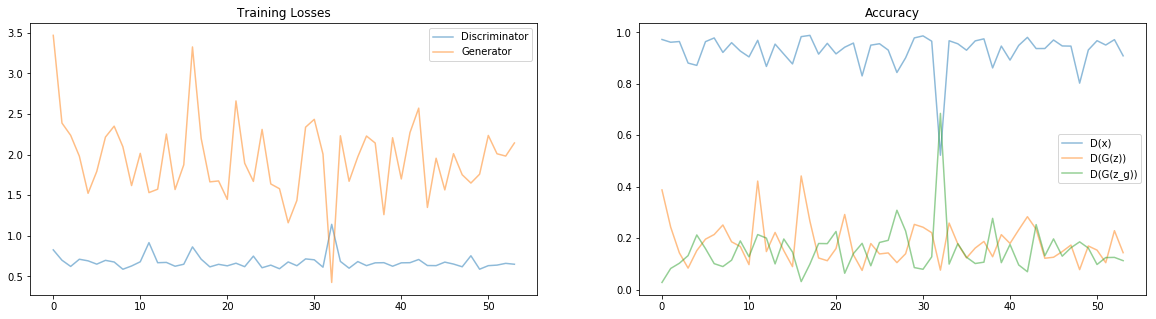

<Figure size 1440x360 with 0 Axes>

In [73]:
plot_model(losses, accuracy)

Model hyperparameters
Image Size: 64x64 - multiplier: 1.0 - in_x: 1.0
Discriminator final layer depth: 32	Generator initial layer depth: 32
Optimizer: lr: 0.0002 - beta1: 0.5 - beta1_delta: 0.0 - beta2: 0.999 - beta2_delta: 0.0
Loss: Metric: bce - Lambda: 1.0 - Delta: 0.0
Z size: 1024 - Number of Conv/Deconv Layers: 5



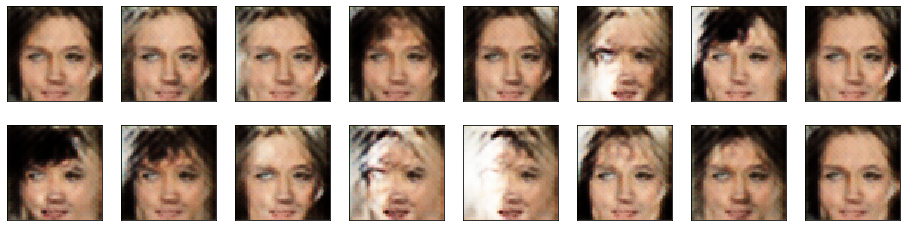

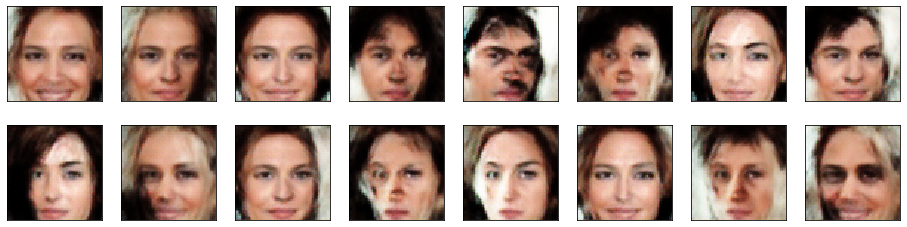

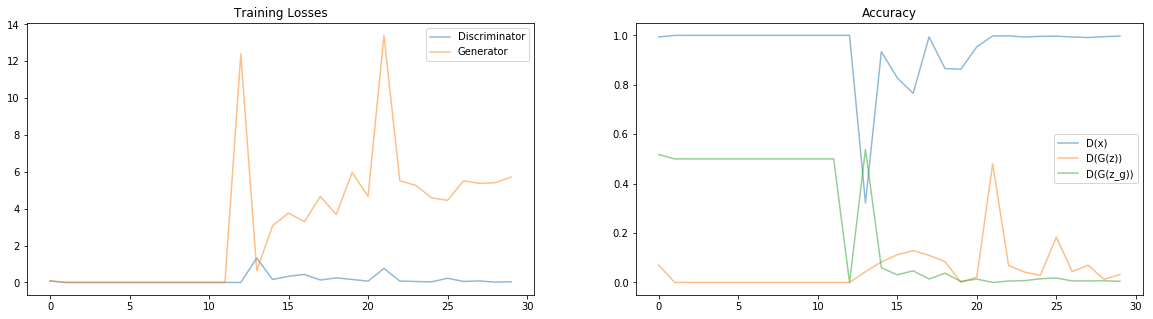

<Figure size 1440x360 with 0 Axes>

In [59]:
plot_model(losses, accuracy)